# 大数据导论期末 Project
组员：
* 赵博弘 11612706
* 郭舒雨 11712932

## Task1：数据预处理

像这类政府收集的信息，一般来说都会以表格的方式存储，数据结构比较简陋，且不说数据缺失是家常便饭，甚至可能混进一些不合法的数据。比如数值型数据中出现其他符号，单词拼写错误，出现与列属性表达规范不同的数据等。

### 预处理之前

* 检查非法数据

1. 对于数值型的，导入过程中以数值类型导入，查看是否会出现报错
2. 对于字符串类型的，在本项目中一般情况为分类数据，直接使用 `DataFrame` 的 `value_counts` 方法，基本上每个 label 都会有比较多的数量，那么只需要检查数量为 1 的数据是否非法即可。

检查到的非法数据，我们会根据情况判断是否丢弃，或者直接在元数据表中修改。

### 缺失值填补

* `Infection_case`：使用 etc 表示未知数结
* `contact_number`：使用 0 填补
* `infected_by`：使用 -1 表示未知的传染者
* `sex`：首先得出已有数据男女比例，然后按该比例生成一共缺失值那么多个 male 和 female 组成的列表，随机打乱该列表并插回源数据
* `age`, `birth_year`：这两个属性有关联性，所以一起填补。观察数据得出，有一部分人没有 `birth_year`，而且仅在那一部分人中，存在二值都缺失的人。于是首先对于两者都缺失的人的 birth_year，以该人所在 `province` 的 `mean` 进行填补，然后可以推导得出这一部分人的 `age`，此时只剩下一部分人有 `age` 且没有 `birth_year`。最后以 `age` 分组，这些人的 `birth_year` 以此人 `age` 组内的 `birth_year` 的 mean 进行填补。
* `country`：直接丢掉这个列
* `city`：因为每个人的 `province` 是完整的，默认认为这个 info 表中的地点为该人的户籍地点，所以直接使用每个人的 route 中去过最多的城市来填补，对于 route 中没有出现的人，直接使用该 `province` 中最多的 `city` 来填补。
* `desease`：进行了转换，有病用1代表，其他用0代表。
* 日期转换：将表中字符串类型的日期转换成内置的日期类

### 新生成数据

* `start_date`：我们想如果能知道一个人的具体的患病日期（而不仅仅是 `symptom_onset_date` 和 `confirmed_date` ）是极为关键的。这样就可以推导出比如像该患者等了多久才去就医的这个时长，过程中有没有去过其他地方进行传播等，对后期的回归预测会有很大帮助。

  首先看该人有没有 `symptom_onset_date` ，如果没有就选择 `confirmed_date` ，作为 `0day`。然后看在 `0day`之前该人的 route 中有没有去过其他地方，对应的会有一系列的时间节点，如果有就从其中选择时间节点与 `0day` 最接近的那个日期作为 `start_date`。如果没有，就选择 `0day` 作为 `start_date`。

* ...



In [1]:
%load_ext autoreload
%autoreload 2
import sys
import random
import folium
from folium import plugins
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import preproc as pp

from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score as f1
from sklearn.metrics import confusion_matrix as con
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics


class COVID(object):
    def __init__(self):
        self.DATA_PATH = "../coronavirusdataset/"
        self.patient_route = pp.patient_route(self.DATA_PATH)
        self.case, self.group_map = pp.case(self.DATA_PATH)
        self.patient_info = pp.patient_info(self.DATA_PATH)
        self.patient_num = self.patient_info.shape[0]
        self.time = pp.time(self.DATA_PATH)
        self.region = pp.region(self.DATA_PATH)
        self.pre_proc()

    def pre_proc(self):
        # >>> patient_info:
        # fill missing value: infection_case, use etc
        self.patient_info["infection_case"].fillna("etc", inplace=True)
        # fill missing value: contact_number, use 0
        self.patient_info["contact_number"].fillna(0, inplace=True)
        # fill missing value: infected_by, use -1
        self.patient_info["infected_by"].fillna(-1, inplace=True)
        # fill missing value: sex, use ratio of all, generate a shuffle list then fill in the blank
        sex_count = dict(self.patient_info["sex"].value_counts())
        sex_num = sex_count["female"] + sex_count["male"]
        un_sex_male = int((self.patient_num - sex_num) * sex_count["male"] / sex_num)
        un_sex_female = int((self.patient_num - sex_num) - un_sex_male)
        fill_sex_list = ["male" for _ in range(0, un_sex_male)] + ["female" for _ in range(0, un_sex_female)]
        random.shuffle(fill_sex_list)
        self.patient_info.loc[self.patient_info["sex"].isnull(), "sex"] = fill_sex_list
        # fill missing value: age, use mean of province
        # # 1. fill birth_year
        all_age = self.patient_info.birth_year.mean()
        province_age = self.patient_info.groupby('province').birth_year.mean()
        province_age.loc[province_age.isnull()] = all_age
        fill_birth_list_idx = self.patient_info.loc[(self.patient_info["birth_year"].isnull()) & (self.patient_info["age"].isnull()), "birth_year"].index
        fill_birth_list = list(province_age[self.patient_info.loc[fill_birth_list_idx, "province"]])
        self.patient_info.loc[(self.patient_info["birth_year"].isnull()) & (self.patient_info["age"].isnull()), "birth_year"] = fill_birth_list
        # # 2. fill age
        fill_age_list_idx = self.patient_info.loc[self.patient_info["age"].isnull(), "age"].index
        cal_year_list = np.array(list(self.patient_info.loc[fill_age_list_idx, "birth_year"]))
        cal_year_list = (2020 - cal_year_list) / 10
        cal_year_list = cal_year_list.astype(int) * 10
        cal_year_list = [str(cal_year_list[i]) + 's' for i in range(cal_year_list.shape[0])]
        self.patient_info.loc[self.patient_info["age"].isnull(), "age"] = cal_year_list
        # fill birth again
        birth_mean = self.patient_info.groupby('age').birth_year.mean()
        fill_birth_list_idx = self.patient_info.loc[self.patient_info["birth_year"].isnull(), "birth_year"].index
        fill_birth_list = list(birth_mean[self.patient_info.loc[fill_birth_list_idx, "age"]])
        self.patient_info.loc[self.patient_info["birth_year"].isnull(), "birth_year"] = fill_birth_list
        # drop country
        self.patient_info.drop(columns=["country"], inplace=True)
        # fill missing value: city
        self.patient_info.loc[self.patient_info["city"] == "etc", "city"] = None
        self.patient_route["most_city"] = self.patient_route.groupby('patient_id').city.transform(
            lambda x: x.value_counts().index[0])
        fill_city_list_idx = self.patient_info.loc[self.patient_info["city"].isnull(), "city"].index
        route_most_city = self.patient_route.groupby('patient_id').most_city.max()
        fill_city_list_pid = self.patient_info.loc[fill_city_list_idx, "patient_id"]
        for idx, pid in fill_city_list_pid.iteritems():
            if pid in route_most_city.index:
                self.patient_info.loc[idx, "city"] = route_most_city[pid]
        self.patient_info["tmp"] = self.patient_info.groupby('province').city.transform(
            lambda x: x.value_counts().index[0])
        fill_city_list_idx = self.patient_info.loc[self.patient_info["city"].isnull(), "city"].index
        prov_most_city = self.patient_info.groupby('province').tmp.max()
        fill_city_list_pid = self.patient_info.loc[fill_city_list_idx, "patient_id"]
        for idx, pid in fill_city_list_pid.iteritems():
            # print(self.patient_info.loc[idx, "province"])
            self.patient_info.loc[idx, "city"] = prov_most_city[self.patient_info.loc[idx, "province"]]
        # fill last city and province
        ttp = self.patient_route.groupby("patient_id").last().reset_index()
        last_index = self.patient_info.loc[self.patient_info["patient_id"].isin(ttp["patient_id"])].index
        last_index = np.array(last_index)
        for idx in range(len(last_index)):
            self.patient_info.loc[self.patient_info.patient_id == ttp.loc[idx, "patient_id"], "last_city"] = ttp.loc[idx, "city"]
            self.patient_info.loc[self.patient_info.patient_id == ttp.loc[idx, "patient_id"], "last_province"] = ttp.loc[idx, "province"]
        null_last_idx = self.patient_info.loc[self.patient_info["last_city"].isnull()].index
        self.patient_info.loc[null_last_idx, "last_city"] = self.patient_info.loc[null_last_idx, "city"]
        self.patient_info.loc[null_last_idx, "last_province"] = self.patient_info.loc[null_last_idx, "province"]
        # fill disease
        self.patient_info["disease_b"] = 1
        self.patient_info.loc[self.patient_info["disease"].isnull(), "disease_b"] = 0
        self.patient_info["disease_b"].value_counts()
        # date formatting
        self.patient_info.loc[776, "symptom_onset_date"] = None
        self.patient_info["confirmed_date"] = pd.to_datetime(self.patient_info.confirmed_date)
        self.patient_info["symptom_onset_date"] = pd.to_datetime(self.patient_info.symptom_onset_date)
        self.patient_info["released_date"] = pd.to_datetime(self.patient_info.released_date)
        self.patient_info["deceased_date"] = pd.to_datetime(self.patient_info.deceased_date)
        self.time["date"] = pd.to_datetime(self.time.date)

        # >>> patient_route:
        self.patient_route["date"] = pd.to_datetime(self.patient_route.date)
        self.patient_info["start_date"] = pd.NaT
        for i, row in self.patient_info.iterrows():
            pid = row["patient_id"]
            dating = self.patient_route[self.patient_route["patient_id"] == pid]
            self.patient_info.loc[self.patient_info["patient_id"] == pid, "group"] = self.group_map[row["infection_case"]]
            if row["symptom_onset_date"] is not pd.NaT:
                if dating.shape[0] == 0:
                    self.patient_info.loc[i, "start_date"] = row["symptom_onset_date"]
                    continue
                dating_b = dating[dating["date"] <= row["symptom_onset_date"]]
                if dating_b.shape[0] == 0:
                    self.patient_info.loc[i, "start_date"] = row["symptom_onset_date"]
                    continue
                self.patient_info.loc[i, "start_date"] = dating_b.tail(1).reset_index().at[0, "date"]
            else:
                if dating.shape[0] == 0:
                    self.patient_info.loc[i, "start_date"] = row["confirmed_date"]
                    continue
                dating_b = dating[dating["date"] <= row["confirmed_date"]]
                if dating_b.shape[0] == 0:
                    self.patient_info.loc[i, "start_date"] = row["confirmed_date"]
                    continue
                self.patient_info.loc[i, "start_date"] = dating_b.tail(1).reset_index().at[0, "date"]
        print(self.patient_info.isnull().sum())
        # fill missing value: sym date
        # self.patient_info.to_excel("./tmp/patient_info.xlsx")
covid_model = COVID()

patient_id               0
sex                      0
birth_year               0
age                      0
province                 0
city                     0
infection_case           0
infected_by              0
contact_number           0
disease               3110
symptom_onset_date    2683
confirmed_date           0
released_date         2147
deceased_date         3072
state                    0
group                    0
tmp                      0
last_city                0
last_province            0
disease_b                0
start_date               0
dtype: int64


## 统计信息与可视化展示

### 性别分布

可见女性患者略多于男性患者，男性的死亡人数多于女性。

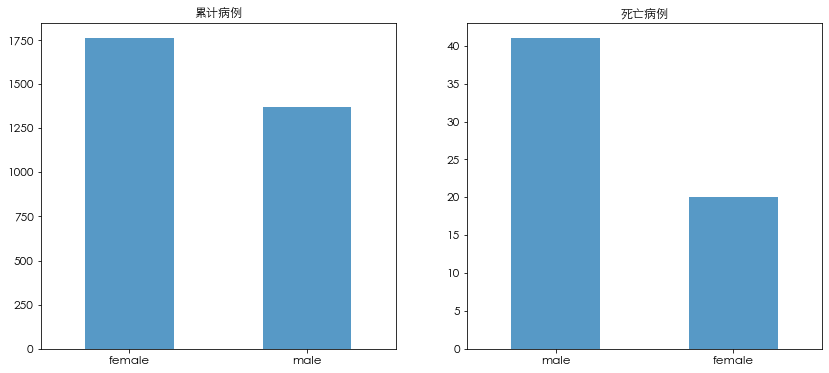

In [35]:
# plot: sex
plt.rcParams['font.family']=['Heiti TC']

deceased = covid_model.patient_info[covid_model.patient_info["state"] == "deceased"]
plt.figure()
plt.rcParams["figure.figsize"] = (14.0, 6.0)
plt.subplot(121)
plt.title("累计病例")
covid_model.patient_info["sex"].value_counts().plot(kind="bar", alpha=0.75, rot=0, fontsize=12)
plt.subplot(122)
plt.title("死亡病例")
deceased["sex"].value_counts().plot(kind="bar", alpha=0.75, rot=0, fontsize=12)
plt.show()

### 案例分布

* etc 这种未知原因还是占很大一部分比例的。所以与 `contact with patient` 和 `overseas inflow` 这两个基数也很大的案例放在一起对比。
* 而对于其他的案例，通常是群体集会行为/前往人群密集区，大部分是在医院接触了其他患者以及教堂的公众集会。

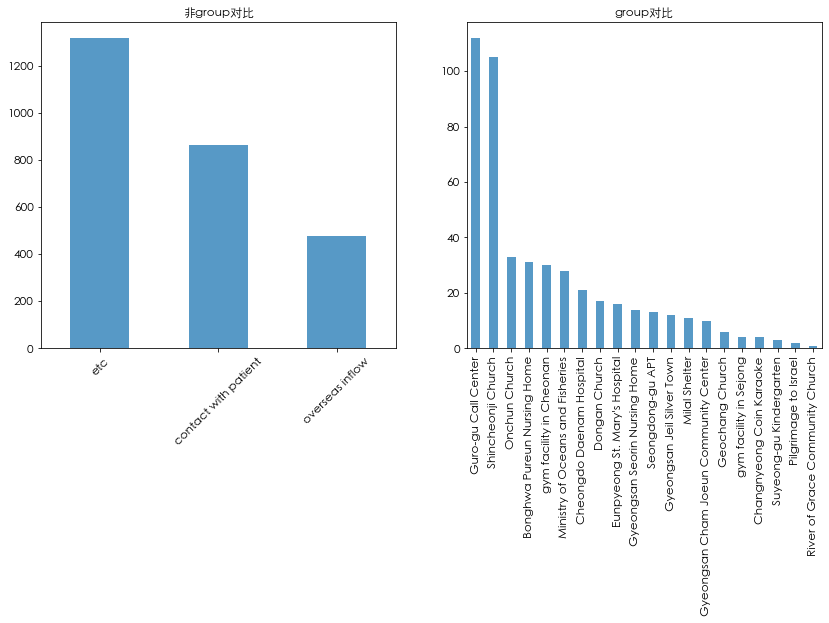

In [68]:
# other infection case
plt.figure()
plt.rcParams["figure.figsize"] = (14.0, 6.0)
plt.subplot(121)
plt.title("非group对比")
covid_model.patient_info["infection_case"].value_counts()[:3].plot(kind="bar", alpha=0.75, rot=45, fontsize=12)
plt.subplot(122)
plt.title("group对比")
covid_model.patient_info["infection_case"].value_counts()[3:].plot(kind="bar", alpha=0.75, rot=90, fontsize=12)
plt.show()

* 死亡者中感染状况为非群体感染的人数较远多于其他情况.

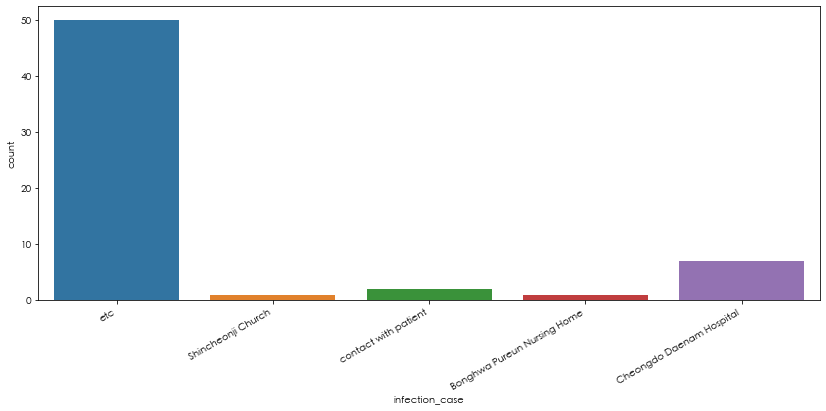

In [53]:
deceased_case=sns.countplot(x="infection_case", data=deceased)
plt.gcf().autofmt_xdate() 

### 城市分布

以下二图为病患的城市分布和热力图

In [162]:
# define the kr map
loc = [36.4268093, 126.5512681]
kr_map = folium.Map(location=loc, zoom_start=7)

# add all patient
incidents = plugins.MarkerCluster().add_to(kr_map)
for lat, lng, label, in zip(covid_model.patient_route.latitude, covid_model.patient_route.longitude, covid_model.patient_route.province):
    folium.Marker(
        location=[lat, lng],
        icon=None,
        popup=label,
    ).add_to(incidents)

# display kr map
kr_map

In [110]:
# define the kr map
loc = [36.4268093, 126.5512681]
kr_map = folium.Map(location=loc, zoom_start=7)

# add heatmap
heatdata = covid_model.patient_route[['latitude','longitude']].values.tolist()
plugins.HeatMap(heatdata).add_to(kr_map)
kr_map

病患城市分布

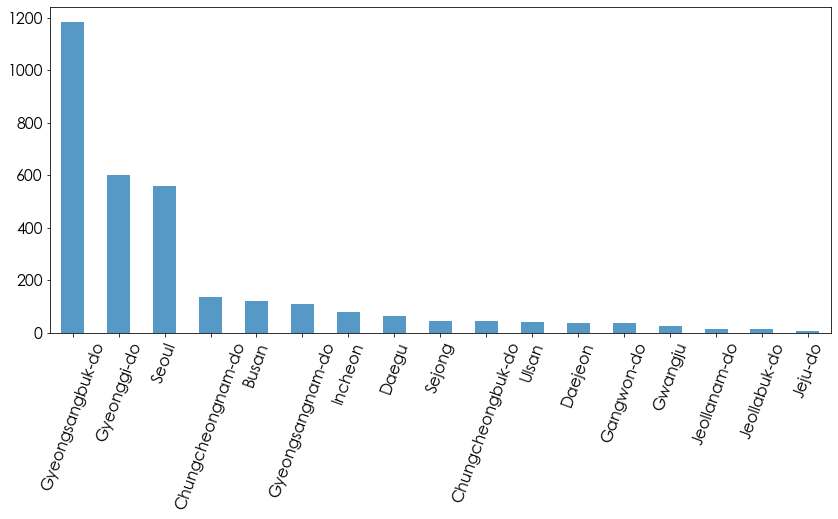

In [60]:
covid_model.patient_info["province"].value_counts().plot(kind="bar", alpha=0.75, rot=70, fontsize=16)

死亡的病人中，最多的是来自Gyeongsangbuk-do和Daegu这两个地方

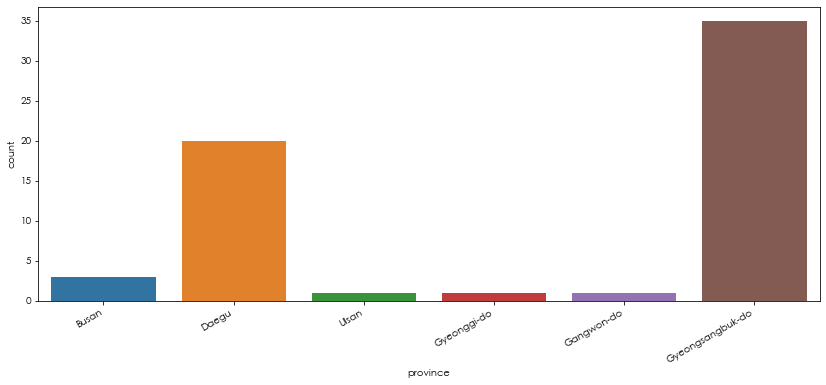

In [61]:
deceased_province=sns.countplot(x="province", data=deceased)
plt.gcf().autofmt_xdate()

### 年龄分布

* 病患主要集中于中老年人和20多岁的年轻人。
* 死亡的病人多为60，70，80代，因此我们可以粗略看出，此病毒对于免疫力低下的老龄人口具有较大的威胁性。死亡的病人多为60，70，80代，因此我们可以粗略看出，此病毒对于免疫力低下的老龄人口具有较大的威胁性。

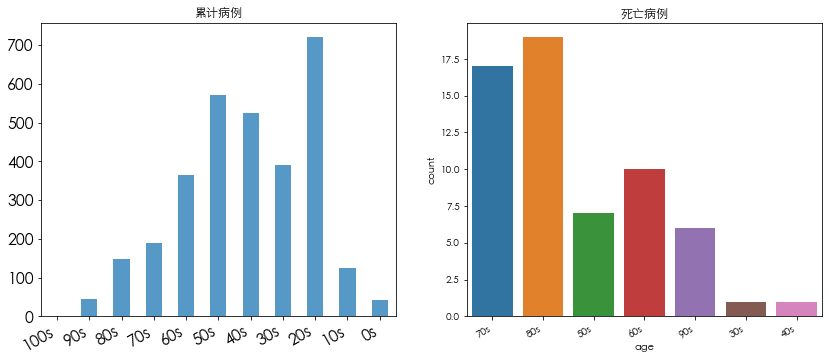

In [89]:
count = covid_model.patient_info["age"].value_counts()
bar = ['100s','90s','80s','70s','60s','50s','40s','30s','20s','10s','0s']
plt.figure()
plt.rcParams["figure.figsize"] = (14.0, 6.0)
plt.subplot(121)
plt.title("累计病例")
count[bar].plot(kind="bar", alpha=0.75, rot=0, fontsize=16)
plt.subplot(122)
plt.title("死亡病例")
deceased_age=sns.countplot(x="age", data=deceased)
plt.gcf().autofmt_xdate()
plt.show()

### 时间分布的数据

#### 病毒检测

可见韩国从三月开始对病毒的检测才踏入正轨。

<Figure size 1008x432 with 0 Axes>

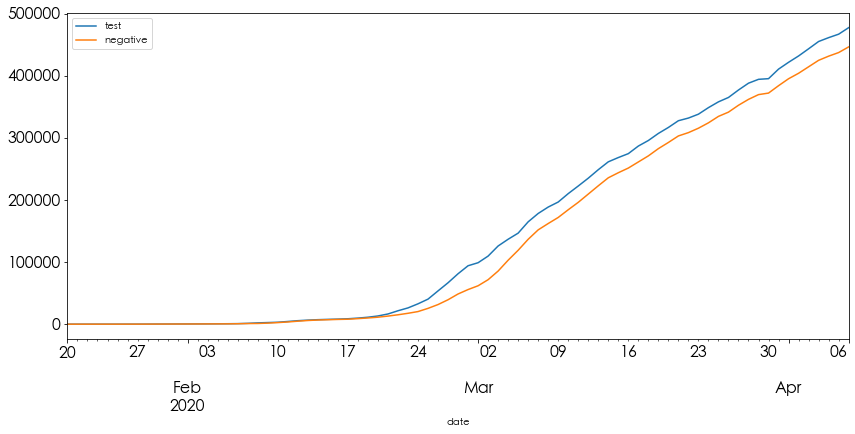

In [119]:
timep = covid_model.time.set_index("date")
plt.figure()
plt.rcParams["figure.figsize"] = (14.0, 6.0)
timep[["test", "negative"]].plot(fontsize=16)
plt.show()

根据累计死亡人数和累计确诊人数的时间序列图，我们可以看出韩国感染人数从2月下旬开始呈现爆发性的增长，到3月中旬增长速度较为缓和，而死亡人数增速一直呈现上升趋势。根据累计死亡人数和累计确诊人数的时间序列图，我们可以看出韩国感染人数从2月下旬开始呈现爆发性的增长，到3月中旬增长速度较为缓和，而死亡人数增速一直呈现上升趋势。

<Figure size 1008x432 with 0 Axes>

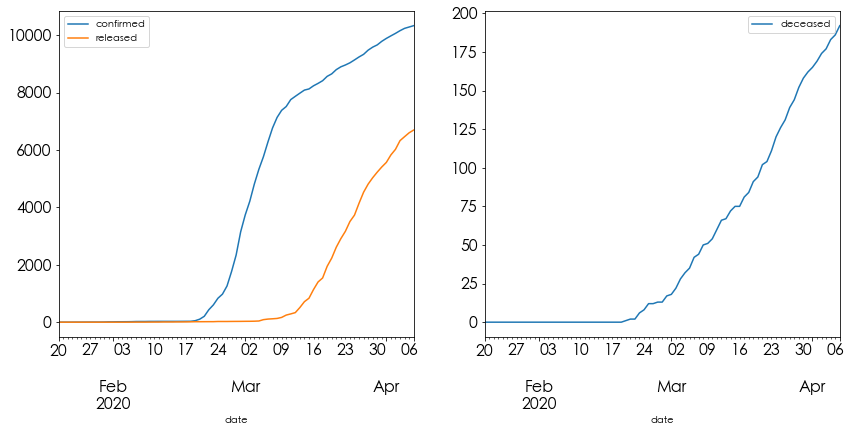

In [121]:
plt.figure()
figure, axes = plt.subplots(1, 2)
plt.rcParams["figure.figsize"] = (14.0, 6.0)
timep[["confirmed", "released"]].plot(fontsize=16, ax=axes[0])
timep[["deceased"]].plot(fontsize=16, ax=axes[1])
plt.show()

## 特征工程

接下来，我们根据patientInfo中的病人籍贯地点对该地点教育水平进行合并，根据PatientRoute的中病人接受治疗的地点对该地点医疗负荷数据进行了合并。我们提取出了状态为released的病人数据，将出院时间和确诊时间进行相减粗略得到病人康复所需时间，并结合并性别、年龄、群体感染与否、学术水平以及医疗负荷水平进行了相关系数的计算。我们发现病人康复所需时间与其他变量之间的相关性非常弱，因此我们认为这些变量对于病人康复所需时间不具有明显的解释性。

In [143]:
region = covid_model.region.copy()
info = covid_model.patient_info.copy()
time = covid_model.time.copy()

info.loc[37, "city"] = "Songpa-gu"
info.loc[106, "city"]="Geumcheon-gu"
info.loc[269, "city"]="Gangnam-gu"
info.loc[385, "city"]="Guro-gu"
info.loc[562, "province"]="Chungcheongnam-do"
info.loc[771, "city"]="Seo-gu"
info.loc[1812, "city"]="Mokpo-si"
info.loc[562, "last_province"]="Chungcheongnam-do"
region["last_province"]=region["province"]
region["last_city"]=region["city"]

new_sex=pd.get_dummies(info["sex"])
info["sex"]=new_sex["male"]#### male 为1
a = np.array(info["group"])
group=a.astype(int)
info["group"]=group#### group 为1

for i in range(len(info["age"])):
    info.loc[i, "age"] = int(info["age"][i].strip("s"))

timeage=pd.read_csv("../coronavirusdataset/TimeAge.csv")
timegender=pd.read_csv("../coronavirusdataset/TimeGender.csv")
timeprovince=pd.read_csv("../coronavirusdataset/TimeProvince.csv")

part1=region[["province","city","elementary_school_count","kindergarten_count","university_count","academy_ratio"]]
part2=region[["last_province","last_city","elderly_population_ratio","elderly_alone_ratio","nursing_home_count"]]
info1=pd.merge(info,part1,on = ["province","city"],how = "left")
final_info=pd.merge(info1,part2,on = ['last_province','last_city'],how = 'left')
released=final_info[final_info["released_date"].isnull()!=True]
released=released[released["state"]=="released"]
rctime=released["released_date"]-released["confirmed_date"]
rctime=rctime.dt.days[0:len(rctime)]
released["recoverytime"]=rctime
names=["sex","age","group","elementary_school_count","kindergarten_count","university_count","academy_ratio",\
       "elderly_population_ratio","elderly_alone_ratio","nursing_home_count"]
x=released[names]
y=released["recoverytime"]
ddd=pd.concat([x,y],axis=1)
ddd.corr() ### 可见recoverytime与其他变量之间的

sex     group  elementary_school_count  \
sex                       1.000000 -0.050915                 0.009009   
group                    -0.050915  1.000000                 0.063677   
elementary_school_count   0.009009  0.063677                 1.000000   
kindergarten_count        0.009470 -0.018200                 0.942532   
university_count         -0.180372 -0.227172                -0.005065   
academy_ratio             0.076846  0.083858                 0.355380   
elderly_population_ratio -0.010878 -0.002591                -0.531670   
elderly_alone_ratio       0.002265  0.026354                -0.442323   
nursing_home_count        0.065492  0.003719                 0.653121   
recoverytime             -0.019096  0.021578                -0.029925   

                          kindergarten_count  university_count  academy_ratio  \
sex                                 0.009470         -0.180372       0.076846   
group                              -0.018200         -0.227172       0.083858   
elementary_school_count             0.942532         -0.005065       0.355380   
kindergarten_count                  1.000000          0.149475       0.308139   
university_count                    0.149475          1.000000      -0.256601   
academy_ratio                       0.308139         -0.256601       1.000000   
elderly_population_ratio           -0.575729         -0.114868      -0.464459   
elderly_alone_ratio                -0.496959         -0.199616      -0.431836   
nursing_home_count                  0.604776         -0.154123       0.521780   
recoverytime                       -0.004614          0.081694      -0.080391   

                          elderly_population_ratio  elderly_alone_ratio  \
sex                                      -0.010878             0.002265   
group                                    -0.002591             0.026354   
elementary_school_count                  -0.531670            -0.442323   
kindergarten_count                       -0.575729            -0.496959   
university_count                         -0.114868            -0.199616   
academy_ratio                            -0.464459            -0.431836   
elderly_population_ratio                  1.000000             0.959882   
elderly_alone_ratio                       0.959882             1.000000   
nursing_home_count                       -0.473543            -0.462866   
recoverytime                              0.075299             0.106244   

                          nursing_home_count  recoverytime  
sex                                 0.065492     -0.019096  
group                               0.003719      0.021578  
elementary_school_count             0.653121     -0.029925  
kindergarten_count                  0.604776     -0.004614  
university_count                   -0.154123      0.081694  
academy_ratio                       0.521780     -0.080391  
elderly_population_ratio           -0.473543      0.075299  
elderly_alone_ratio                -0.462866      0.106244  
nursing_home_count                  1.000000     -0.134891  
recoverytime                       -0.134891      1.000000

我们接下来对病人是否死亡或者出院进行了分类预测。主要利用性别、年龄、群体感染与否、学术水平以及医疗负荷水平等变量。

In [144]:
dataclf=final_info[final_info["state"]!="isolated"]
iso=final_info[final_info["state"]=="isolated"]
names=["sex","age","group","disease_b","elementary_school_count","kindergarten_count","university_count","academy_ratio",
              "elderly_population_ratio","elderly_alone_ratio" ,"nursing_home_count"]
y = dataclf["state"]
x = dataclf[names]
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)
print(y_test.value_counts()/len(y_test))
print(y_train.value_counts()/len(y_train))

released    0.952646
deceased    0.047354
Name: state, dtype: float64
released    0.947305
deceased    0.052695
Name: state, dtype: float64


### 朴素贝叶斯模型

In [145]:
classifier = MultinomialNB().fit(x_train,y_train)
test_pred = classifier.predict(x_test)
train_pred = classifier.predict(x_train)

#### 模型性能评估

根据朴素贝叶斯模型的分类结果，可以看出运用该种方法分类的precision较低，但是recall召回率较高，但是有较多实际为released的病人被误分为deceased。若按照这种方法为院方进行分类估计，易给医院造成较大的负担和压力。

In [148]:
print(metrics.confusion_matrix(y_test, test_pred), "\n")
print(metrics.classification_report(y_test,test_pred))

[[ 17   0]
 [ 96 246]] 

              precision    recall  f1-score   support

    deceased       0.15      1.00      0.26        17
    released       1.00      0.72      0.84       342

    accuracy                           0.73       359
   macro avg       0.58      0.86      0.55       359
weighted avg       0.96      0.73      0.81       359



### 随机森林

In [151]:
rf = RandomForestClassifier(class_weight='balanced',random_state=1)
###返回由训练集训练成的模型对验证集预测的结果
test_pred = rf.fit(x_train,y_train).predict(x_test)
###打印混淆矩阵
print('\n'+'混淆矩阵：')
print(con(y_test,test_pred))
###打印测试准确率
print('\n'+'Accuracy:')
print(rf.score(x_test,y_test), "\n")
print(metrics.classification_report(y_test,test_pred))


混淆矩阵：
[[ 13   4]
 [  5 337]]

Accuracy:
0.9749303621169917 

              precision    recall  f1-score   support

    deceased       0.72      0.76      0.74        17
    released       0.99      0.99      0.99       342

    accuracy                           0.97       359
   macro avg       0.86      0.88      0.86       359
weighted avg       0.98      0.97      0.98       359



对比朴素贝叶斯，我们可以看到运用了随机森林的算法分类的效果更好。更多的实际出院病人被进行了正确的预测分类。

从下面的计算和作图中，我们可以看到年龄是最重要的特征，相比年轻人，高龄病人更容易死亡，我们可以看到文化水平和医疗水平等相关的变量的重要性远
小于年龄，而性别，是否为群体感染，是否患病对于病人是否死亡并没有特别大的作用。我们接下来对随机森林进行参数的调优。

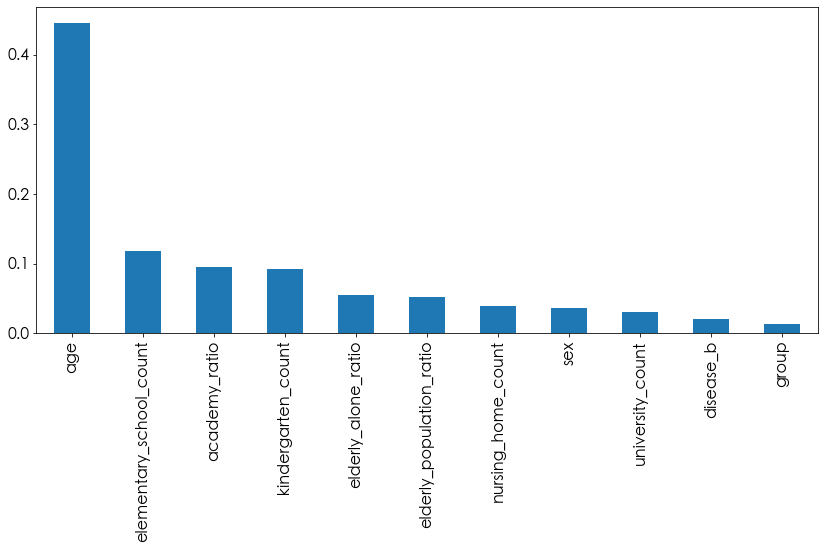

In [156]:
feature_imp = pd.Series(rf.feature_importances_)
feature_imp.index = x.columns
sorteds_features = feature_imp.sort_values(ascending=False)
sorteds_features
# The following is DataFrame format of the feature importance vector
feature_impDF = pd.DataFrame()
feature_impDF["importance"] = rf.feature_importances_
feature_impDF["feature"] = x.columns
feature_impDF.sort_values("importance",ascending=False,inplace=True)
feature_impDF
sorteds_features.plot(kind="bar", fontsize=16)

### 随机森林进行调优

In [157]:
from sklearn.model_selection import GridSearchCV
import numpy as np
rf2 = RandomForestClassifier()
parameters = {"n_estimators":np.arange(10,100,10),"criterion":["gini","entropy"]}
grid_rf2 = GridSearchCV(estimator=rf2, param_grid=parameters, cv=5,scoring="accuracy")
grid_rf2.fit(x_train,y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
             scoring='accuracy')

In [158]:
print(grid_rf2.best_params_)

{'criterion': 'gini', 'n_estimators': 60}


根据网格计算，我们得到，最优的迭代为20次，此时的标准是gini指数。下面是运用这两个优化的参数进行新模型的建立。

In [159]:
rf3 = RandomForestClassifier(class_weight='balanced',random_state=1,criterion="gini", n_estimators=20)
###返回由训练集训练成的模型对验证集预测的结果
test_pred = rf3.fit(x_train,y_train).predict(x_test)
###打印混淆矩阵
print('\n'+'混淆矩阵：')
print(con(y_test,test_pred))
###打印测试准确率
print('\n'+'Accuracy:')
print(rf3.score(x_test,y_test))


混淆矩阵：
[[ 13   4]
 [  4 338]]

Accuracy:
0.9777158774373259


In [160]:
print(metrics.classification_report(y_test,test_pred))

              precision    recall  f1-score   support

    deceased       0.76      0.76      0.76        17
    released       0.99      0.99      0.99       342

    accuracy                           0.98       359
   macro avg       0.88      0.88      0.88       359
weighted avg       0.98      0.98      0.98       359



优化后的新随机森林模型对于死亡病人的预测召回率有所下降，而对于康复病人的预测召回率有所提升，总体来讲，rg3模型对于病人的状态分类效果有所提升。
以下我们考虑 KNN 模型。

### KNN

In [163]:
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier(n_neighbors = 11)
knn_model.fit(x_train,y_train)
test_pred = knn_model.predict(x_test)
from sklearn import metrics
print(metrics.classification_report(y_test,test_pred))
print(metrics.confusion_matrix(y_test,test_pred))
print(metrics.accuracy_score(y_test,test_pred))

              precision    recall  f1-score   support

    deceased       0.62      0.47      0.53        17
    released       0.97      0.99      0.98       342

    accuracy                           0.96       359
   macro avg       0.79      0.73      0.76       359
weighted avg       0.96      0.96      0.96       359

[[  8   9]
 [  5 337]]
0.9610027855153204


我们可以看到，过半死亡状态的病人被预测为出院状态，因此对于死亡状态的预测不够准确，需要优化KNN模型。我们设置了k=1至21之间的奇数，对这些k的值都进行了模型拟合。

In [164]:
k_list=[1,3,5,7,9,11,13,15,17,19,21]
for k in k_list:
    knn_model = KNeighborsClassifier(n_neighbors = k)
    knn_model.fit(x_train,y_train)
    test_pred = knn_model.predict(x_test)
    accuracy = metrics.accuracy_score(y_test,test_pred)
    confusion_mat = metrics.confusion_matrix(y_test,test_pred)
    
    print("k = ",k)
    print("\t正确率: ", '%.2f'%(accuracy*100) + "%")
    print("\t假阴性：",confusion_mat[0,1]/(confusion_mat[0,1]+confusion_mat[0,0]))
    print("","\t假阳性：",confusion_mat[1,0]/(confusion_mat[1,0]+confusion_mat[1,1]))

k =  1
	正确率:  97.21%
	假阴性： 0.35294117647058826
 	假阳性： 0.011695906432748537
k =  3
	正确率:  97.77%
	假阴性： 0.35294117647058826
 	假阳性： 0.005847953216374269
k =  5
	正确率:  96.66%
	假阴性： 0.5882352941176471
 	假阳性： 0.005847953216374269
k =  7
	正确率:  96.66%
	假阴性： 0.5882352941176471
 	假阳性： 0.005847953216374269
k =  9
	正确率:  96.94%
	假阴性： 0.4117647058823529
 	假阳性： 0.011695906432748537
k =  11
	正确率:  96.10%
	假阴性： 0.5294117647058824
 	假阳性： 0.014619883040935672
k =  13
	正确率:  95.82%
	假阴性： 0.7647058823529411
 	假阳性： 0.005847953216374269
k =  15
	正确率:  95.82%
	假阴性： 0.7647058823529411
 	假阳性： 0.005847953216374269
k =  17
	正确率:  96.10%
	假阴性： 0.7647058823529411
 	假阳性： 0.0029239766081871343
k =  19
	正确率:  96.38%
	假阴性： 0.7058823529411765
 	假阳性： 0.0029239766081871343
k =  21
	正确率:  96.38%
	假阴性： 0.7058823529411765
 	假阳性： 0.0029239766081871343


可以看出预测出的假阴性所占的比例随k值增大逐渐上升，准确率逐渐下降，当k等于1的时候，假阴性为0.35，对于我们之前优化过的随机森林模型（假阴性为0.24），knn模型在这里并不是最优的模型。
综上我们选择调优过后的随机森林模型rg3作为一个较好的分类出院和病死的分类模型。

## Task3：城市危险等级

目前仅对城市相关的数据进行了聚合，未想出如何去解释城市的聚类中心，以及如何设定适度函数。

In [11]:
# task 3 risk levels of the cities
cr = covid_model.region.copy()
cr["count"] = 0
cr["released"] = 0
cr["isolated"] = 0
cr["deceased"] = 0

cnt = covid_model.patient_info.groupby(["province", "city"]).agg({'patient_id': ['count']})
cnt.columns = ['count']
cnt["released"] = 0
cnt["isolated"] = 0
cnt["deceased"] = 0
cnt = cnt.reset_index()
nc = pd.DataFrame(covid_model.patient_info.groupby(["province", "city"])["state"].value_counts())
nc.columns = ['count']
nc = nc.reset_index()
for row in nc.itertuples():
    cnt.loc[(cnt["province"]==getattr(row, "province"))&(cnt["city"]==getattr(row, "city")), getattr(row, "state")] = getattr(row, "count")

ccc = 0
for row in cnt.itertuples():
    if cr.loc[(cr["province"]==getattr(row, "province"))&(cr["city"]==getattr(row, "city"))].shape[0] == 0:
        continue
    cr.loc[(cr["province"]==getattr(row, "province"))&(cr["city"]==getattr(row, "city")), "count"] = getattr(row, "count")
    covid_model.region.loc[(covid_model.region["province"]==getattr(row, "province"))&(cr["city"]==getattr(row, "city")), "released"] = getattr(row, "released")
    cr.loc[(cr["province"]==getattr(row, "province"))&(cr["city"]==getattr(row, "city")), "isolated"] = getattr(row, "isolated")
    cr.loc[(cr["province"]==getattr(row, "province"))&(cr["city"]==getattr(row, "city")), "deceased"] = getattr(row, "deceased")

dcr = cr.drop(columns=["province", "city"])
k = 5
km = KMeans(n_clusters=k)
km.fit(dcr)
cent = km.cluster_centers_
km.labels_

array([2, 3, 4, 4, 4, 4, 4, 4, 0, 4, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0,
       4, 4, 4, 4, 3, 0, 0, 0, 0, 0, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 4, 3,
       0, 4, 0, 4, 4, 0, 4, 4, 3, 4, 0, 0, 4, 4, 3, 0, 0, 4, 4, 0, 4, 4,
       0, 0, 0, 3, 0, 0, 4, 4, 0, 4, 4, 0, 0, 0, 0, 0, 2, 0, 4, 0, 0, 0,
       0, 0, 4, 4, 0, 4, 4, 4, 4, 4, 0, 4, 0, 0, 0, 0, 0, 4, 0, 4, 0, 4,
       4, 0, 0, 4, 3, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 4, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0,
       3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 3, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 4, 3, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 4, 0, 4, 0, 0, 0, 0, 0,
       4, 1], dtype=int32)

## Task4：基于地理的分析

在附件中 `task4.gif` 这个动图展示了随着时间变化，病患往返路径的累计描述以及，病患活动地点的聚类中心的变化。聚类过程使用了 K-means 算法，并设定 k=10。可见病患活跃城市从一开始的很跳跃的状态逐步趋于稳定，中心皆为韩国人口众多的大城市。且从图中可以得出，一是韩国首都首尔连接的路径呈放射状，然后还有三至四条很明显的患病移动“干路”。切断这些城市之间的交通，可以比较好的延缓疫情发展态势。

In [167]:
# task 4 line route in 
# define the kr map

kkk = 10

loc = [35.8268093, 127.8512681]
kr_map = folium.Map(location=loc, zoom_start=7)

for k0, group in covid_model.patient_route.groupby("patient_id"):
    rt = list(zip(group["latitude"], group["longitude"]))
    folium.PolyLine(rt, weight=1).add_to(kr_map)

pos = covid_model.patient_route[["latitude", "longitude"]]
km = KMeans(n_clusters=kkk)
km.fit(pos)
cent = km.cluster_centers_
for point in range(0, kkk):
    folium.Marker(cent[point]).add_to(kr_map)

kr_map

In [168]:
import datetime
import time
import imageio
import os,sys
from selenium import webdriver
from pprint import pprint
import glob
e=sys.exit
kkk = 10
swc = False
if swc:
    print(covid_model.patient_route["date"].max())
    begin = datetime.date(2020,2,9)
    end = datetime.date(2020,3,30)
    delta = datetime.timedelta(days=1)
    day = begin
    dest_folder = "tmp/route_gif/"
    while day <= end:
        loc = [35.8268093, 127.8512681]
        kr_map = folium.Map(location=loc, zoom_start=8)
        ds = day.strftime("%Y-%m-%d")
        c_day_route = covid_model.patient_route.loc[covid_model.patient_route["date"] <= ds]
        if c_day_route.shape[0]:
            for k0, group in c_day_route.groupby("patient_id"):
                rt = list(zip(group["latitude"], group["longitude"]))
                folium.PolyLine(rt, weight=1).add_to(kr_map)
        pos = c_day_route[["latitude", "longitude"]]
        km = KMeans(n_clusters=kkk)
        km.fit(pos)
        cent = km.cluster_centers_
        for point in range(0, kkk):
            folium.Marker(cent[point]).add_to(kr_map)
        filename = ds+".html"
        kr_map.save(dest_folder+filename)
        folium_map_to_png(filename, "/" + dest_folder)
        # display(kr_map)
        # time.sleep(4)
        day += delta

if swc:
    images = []
    begin = datetime.date(2020,1,24)
    end = datetime.date(2020,3,30)
    delta = datetime.timedelta(days=1)
    day = begin
    dest_folder = "tmp/route_gif/"
    duration = 10
    while day <= end:
        filename = dest_folder + day.strftime("%Y-%m-%d") + ".png"
        images.append(imageio.imread(filename))
        day += delta
    output_file = '1Gif.gif'
    imageio.mimsave(dest_folder + output_file, images, duration=1/15)

## Task6：年龄分组

使用了 K-means 聚类算法，分布展示了 k=2,3,4,5 时的年龄聚集中心。

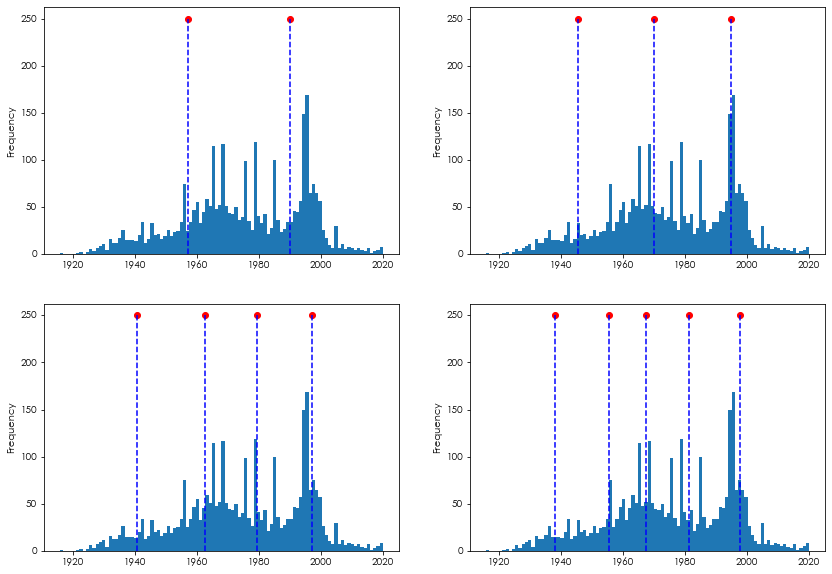

In [171]:
# task 6
from sklearn.cluster import KMeans
kkk = 3
plt.figure()
plt.rcParams["figure.figsize"] = (14.0, 10.0)
for kkk in range(2, 6):
    birth = covid_model.patient_info["birth_year"]
    birth_np = np.array(birth)
    birth_np = birth_np.reshape(-1, 1)
    km = KMeans(n_clusters=kkk)
    km.fit(birth_np)
    cent = km.cluster_centers_
    # print(cent)
    plt.subplot(219 + kkk)
    ppt = covid_model.patient_info["birth_year"].plot.hist(bins=100)
    plt.scatter(km.cluster_centers_, [250 for _ in range(kkk)], c='r')
    for i in range(kkk):
        plt.plot([cent[i], cent[i]], [0, 250], c='b', linestyle='--')

## Conclusion

根据分析，我们发现，病人的年龄对于病人是否会死亡具有极大的影响作用。该项肺炎对于具有较低免疫力的高龄的人口（60代以上）具有较大的威胁，因此老人需要格外注意防护和隔离。由于韩国初期没有进行即时的防疫措施，最开始有病人在首尔周边以及大邱周边进行移动造成了病毒的传播，导致病毒在各个城市逐渐进行蔓延，最终达到急速增长的情况，因此在病毒发生初期即时地切断城市之间的联通渠道能够较好地防止病毒在全国范围内的广泛传播。此外我们还发现不同年龄段的人针对病毒的免疫力可以分成不同的类，较为高龄的人群更容易感染病毒。在四月下旬，韩国也颁布了法规，进行了相应的强制隔离措施，人们的防疫意识也有所提高。我们有理由相信韩国的未来疫情将会得到良好的改善。